#Imports

In [1]:
import math
from random import sample
from random import randint
import os

!pip install comet-ml &> /dev/null
import comet_ml

!pip install pytorch-lightning &> /dev/null
import pytorch_lightning as pl
from pytorch_lightning.loggers import CometLogger
import tensorboard
import numpy as np

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import cv2
from PIL import Image
from IPython import display

!pip install pytorch-msssim &> /dev/null
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

!pip install dlib &> /dev/null
import dlib

import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

from google.colab import drive
drive.mount('/content/drive')

MAFIA_FILEPATH = "/content/drive/My Drive/MafiaVideogame.mp4"
GODFATHER_FILEPATH = "/content/drive/My Drive/TheGodfather.mp4"
IRISHMAN_FILEPATH = "/content/drive/My Drive/TheIrishman.mp4"
SOPRANOS_FILEPATH = "/content/drive/My Drive/TheSopranos.mp4"

Mounted at /content/drive


# Preprocessing  (1.1)

## Frame Loading

In [2]:
def load_video(filepath, start_frame=0, end_frame=-1):
    # import video
    video = cv2.VideoCapture(filepath)
    # get frame size (to size array) and number of frames
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/ resizing image
    scale_percent = 50
    width = int(frame_width * scale_percent / 100)
    height = int(frame_height * scale_percent / 100)
    dim = (width, height)
    
    if end_frame == -1 or end_frame > frame_count:
        end_frame = frame_count

    frames = np.empty((end_frame-start_frame, height, width, 3), np.dtype('uint8'))
    video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    for frame in tqdm(range(start_frame ,min(end_frame,frame_count))):
        success, img = video.read()
        if not success: break
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # reduce image size to help model memory
        frames[frame] = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

    video.release()
    return frames

def load_video_random_frames(filepath, number_of_frames, start_frame=0, end_frame=None):
    # import video
    video = cv2.VideoCapture(filepath)
    # get frame size (to size array) and number of frames
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    if not end_frame:
        end_frame = frame_count - 1 
    
    # https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/ resizing image
    #scale_percent = 10 # 120x72 image size
    width = 128 #int(frame_width * scale_percent / 100)
    height = 128 #int(frame_height * scale_percent / 100)
    dim = (width, height)                
    
    frames = np.empty((number_of_frames, height, width, 3), np.dtype('uint8'))
    
    used_frames = []
    for frame in tqdm(range(number_of_frames)):
        num = randint(start_frame, end_frame)
        while True:
            if num not in used_frames:
                used_frames.append(num)
                break
            num = randint(0,frame_count-1)
        video.set(cv2.CAP_PROP_POS_FRAMES,num)
        success, img = video.read()
        if not success: break
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # reduce image size to help model memory
        frames[frame] = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
                     
    video.release()
    return frames

## Extract Frames/Faces [Tests]

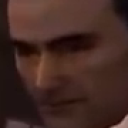

In [ ]:
d = display.display(None, display_id=True)
MAFIA_FRAMES = load_video_random_faces(MAFIA_FILEPATH,2)
#GODFATHER_FRAMES = load_video_random_frames(GODFATHER_FILEPATH)
#IRISHMAN_FRAMES = load_video_random_frames(IRISHMAN_FILEPATH)
#SOPRANOS_FRAMES = load_video_random_frames(SOPRANOS_FILEPATH)

d.update(Image.fromarray(MAFIA_FRAMES[0]))
from time import sleep
sleep(5)
d.update(Image.fromarray(MAFIA_FRAMES[1]))

# view frames

#for count, frame in enumerate(MAFIA_FRAMES):
#    d.update(Image.fromarray(frame))



#Preprocessing (Faces 3.1)

In [2]:
def within_bounds(centre, width, height, frame_size):
    max_height, max_width = frame_size[0], frame_size[1]
    if centre.x - width//2 < 0 or centre.x + width//2 >= max_width:
        return False
    if centre.y - height//2 < 0 or centre.y + height//2 >= max_height:
        return False
    return True

def extract_faces(frame):
    dim = (128, 128) 
    detector = dlib.get_frontal_face_detector()
    dets, scores, _ = detector.run(frame, 1, -1)
    faces = []
    for img, score in zip(dets, scores):
        if score < 0: continue
        # location and size of the face
        centre, width, height = img.dcenter(), img.width(), img.height()
        if within_bounds(centre, width, height, np.shape(frame)):
            crop = frame[centre.y-height//2:centre.y+height//2, centre.x-width//2:centre.x+width//2]
            faces.append(cv2.resize(crop, dim, interpolation=cv2.INTER_AREA))
    if len(faces) > 0:
        return faces, True
    else:
        return None, False

def load_video_random_faces(filepath, number_of_faces, start_frame=0, end_frame=None):
    # import video
    video = cv2.VideoCapture(filepath)
    # get frame size (to size array) and number of frames
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    if not end_frame:
        end_frame = frame_count - 1 
    
    # full res for face detection, trim detected faces to size                
    face_height = face_width = 128
    dim = (face_width, face_height)
    final_faces = np.empty((number_of_faces, face_height, face_width, 3), np.dtype('uint8'))
    
    used_frames = []
    current_face = 0
    with tqdm(total=number_of_faces) as pbar:
        while current_face < number_of_faces:
            num = randint(start_frame, end_frame)
            while True:
                if num not in used_frames:
                    used_frames.append(num)
                    break
                num = randint(0,frame_count-1)
            video.set(cv2.CAP_PROP_POS_FRAMES,num)
            success, frame = video.read()
            if not success: break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            faces, success = extract_faces(frame)
            if success:
                for face in faces:
                    if current_face >= number_of_faces: break
                    final_faces[current_face] = face
                    current_face += 1
                    pbar.update(1)
    video.release()
    return final_faces

# Frame-to-Frame Model (2.1)

###Dataset

In [3]:
class GameMovieDataset(Dataset):
    def __init__(self, game_frames, movie_frames):
        self.game_frames = game_frames
        self.movie_frames = movie_frames

    def __len__(self):
        return min([len(self.game_frames), len(self.movie_frames)])

    def __getitem__(self, idx):        
        game_img = self.game_frames[idx]
        mov_img = self.movie_frames[idx]

        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.RandomChoice([torchvision.transforms.RandomVerticalFlip(),
                                                                                        torchvision.transforms.RandomHorizontalFlip(),
                                                                                        torchvision.transforms.GaussianBlur(3),
                                                                                        torchvision.transforms.ColorJitter()])])
        game_img = transform(game_img)
        mov_img = transform(mov_img)

        return game_img, mov_img

###Frame Data

In [4]:
MAFIA_FRAMES = load_video_random_frames(MAFIA_FILEPATH, 1500)
GODFATHER_FRAMES = load_video_random_frames(GODFATHER_FILEPATH, 500)
IRISHMAN_FRAMES = load_video_random_frames(IRISHMAN_FILEPATH, 500)
SOPRANOS_FRAMES = load_video_random_frames(SOPRANOS_FILEPATH, 500)
game_frames = MAFIA_FRAMES
movie_frames = np.concatenate((GODFATHER_FRAMES, IRISHMAN_FRAMES, SOPRANOS_FRAMES), axis=0)

100%|██████████| 500/500 [01:40<00:00,  4.98it/s]


###Face Data

In [4]:
# faces not frames but keeping for variable consistency in the next block
#from google.colab import drive
#import pickle
#
#path = F"/content/drive/My Drive/mafia-faces.p"
#MAFIA_FRAMES = load_video_random_faces(MAFIA_FILEPATH, 1000)
#pickle.dump(MAFIA_FRAMES, open(path, "wb"))
#
#path = F"/content/drive/My Drive/godfather-faces.p"
#GODFATHER_FRAMES = load_video_random_faces(GODFATHER_FILEPATH, 333)
#pickle.dump(GODFATHER_FRAMES, open(path, "wb"))
#
#path = F"/content/drive/My Drive/irishman-faces.p"
#IRISHMAN_FRAMES = load_video_random_faces(IRISHMAN_FILEPATH, 333)
#pickle.dump(IRISHMAN_FRAMES, open(path, "wb"))
#
#path = F"/content/drive/My Drive/sopranos-faces.p"
#SOPRANOS_FRAMES = load_video_random_faces(SOPRANOS_FILEPATH, 333)
#pickle.dump(SOPRANOS_FRAMES, open(path, "wb"))


from google.colab import drive
import pickle
drive.mount('/content/drive')
path = F"/content/drive/My Drive/mafia-faces.p"
MAFIA_FRAMES = pickle.load(open(path, "rb"))
path = F"/content/drive/My Drive/godfather-faces.p"
GODFATHER_FRAMES = pickle.load(open(path, "rb"))
path = F"/content/drive/My Drive/irishman-faces.p"
IRISHMAN_FRAMES = pickle.load(open(path, "rb"))
path = F"/content/drive/My Drive/sopranos-faces.p"
SOPRANOS_FRAMES = pickle.load(open(path, "rb"))

game_frames = MAFIA_FRAMES
movie_frames = np.concatenate((GODFATHER_FRAMES, IRISHMAN_FRAMES, SOPRANOS_FRAMES, load_video_random_faces(IRISHMAN_FILEPATH, 1)), axis=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


##Dataset Loading

In [5]:
# split frames into train/val/test (80/10/10 split)
indicies = list(range(len(game_frames)))
train_indicies = sample(indicies, int(len(indicies)*0.8))

non_train_indicies = set(indicies) - set(train_indicies)
val_indicies = sample(non_train_indicies, int(len(non_train_indicies)*0.5))

test_indicies = list(set(non_train_indicies) - set(val_indicies))

train_game_frames = []
val_game_frames = []
test_game_frames = []

train_mov_frames = []
val_mov_frames = []
test_mov_frames = []

for idx in train_indicies:
    train_game_frames.append(game_frames[idx])
    train_mov_frames.append(movie_frames[idx])

for idx in val_indicies:
    val_game_frames.append(game_frames[idx])
    val_mov_frames.append(movie_frames[idx])

for idx in test_indicies:
    test_game_frames.append(game_frames[idx])
    test_mov_frames.append(movie_frames[idx])

# train dataset
train_dataset = GameMovieDataset(train_game_frames, train_mov_frames)

# validation dataset
val_dataset = GameMovieDataset(val_game_frames, val_mov_frames)

# test dataset
test_dataset = GameMovieDataset(test_game_frames, test_mov_frames)

##Generator

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        channels = 3
        nf = 64
        
        def downsample_convolution(in_features, out_features):
            return nn.Sequential(nn.Conv2d(in_features, out_features, 4, 2, 1),
                        nn.InstanceNorm2d(out_features),
                        nn.LeakyReLU(0.2))
        
        def residual_convolution(in_features):
             return nn.Sequential(nn.Conv2d(in_features, in_features, 3, 1, 1))
        
        def post_residual(in_features, out_features):
            return nn.Sequential(nn.Conv2d(in_features, out_features, 3, 1, 1))
        
        def upsample_convolution(in_features, out_features):
            return nn.Sequential(nn.ConvTranspose2d(in_features, out_features, 4, 2, 1),
                        nn.InstanceNorm2d(out_features, 0.8),
                        nn.ReLU())
        
        # resize-conv to mitigate checkerboard artifacts
        #def upsample_convolution(in_features, out_features):
        #    return nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        #                        nn.ReflectionPad2d(1),
        #                        nn.Conv2d(in_features, out_features, kernel_size=3, stride=1, padding=0),
        #                        nn.InstanceNorm2d(out_features, 0.8),
        #                        nn.ReLU())
            
        # first conv
        self.conv1 = nn.Sequential(
                    nn.Conv2d(channels, nf, 4, 2, 1),
                    nn.LeakyReLU())
        # downsample
        self.downsample1 = downsample_convolution(nf,nf*2)
        # residual block 1
        self.residual1 = residual_convolution(nf*2)
        self.post_residual1 = post_residual(nf*2 + nf*2, nf*2)
        # downsample
        self.downsample2 = downsample_convolution(nf*2,nf*4)
        # residual block 2
        self.residual2 = residual_convolution(nf*4)
        self.post_residual2 = post_residual(nf*4 + nf*4, nf*4)
        # upsample
        self.upsample1 = upsample_convolution(nf*4, nf*2)
        # residual block 3
        self.residual3 = residual_convolution(nf*4)
        self.post_residual3 = post_residual(nf*4+nf*4, nf*4)
        # upsample
        self.upsample2 = upsample_convolution(nf*4, nf*2)
        # final conv
        self.conv2 = nn.Sequential(
                    nn.ConvTranspose2d(nf*2, channels, 4, 2, 1),
                    nn.Sigmoid())
    
    def forward(self, x):
        # first conv
        x = self.conv1(x)
        # downsample
        pre_residual1_x = self.downsample1(x)
        # residual block 1
        x = torch.cat([pre_residual1_x, self.residual1(pre_residual1_x)], dim=1)
        pre_skip_x = self.post_residual1(x) # use in skip connect
        # downsample
        pre_residual2_x = self.downsample2(pre_skip_x)
        # residual block 2
        x = torch.cat([pre_residual2_x, self.residual2(pre_residual2_x)], dim=1)
        x = self.post_residual2(x)
        # upsample
        pre_residual3_x = self.upsample1(x)
        x = torch.cat([pre_residual3_x, pre_skip_x], dim=1) # skip connect
        # residual block 3
        x = torch.cat([x, self.residual3(x)], dim=1)
        x = self.post_residual3(x)
        # upsample
        x = self.upsample2(x)
        # final conv
        x = self.conv2(x)
        return x

##Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        nf = 32
        channels = 3
        
        def dilated_convolution(in_features, out_features, dilation):
            return nn.Sequential(nn.Conv2d(in_features, out_features, 3, 1, dilation, dilation),
                            nn.InstanceNorm2d(out_features),
                            nn.LeakyReLU(0.2, inplace=True))

        def convolution(in_features, out_features, kernal_size=4, stride=2, padding=1):
            return nn.Sequential(nn.Conv2d(in_features, out_features, kernal_size, stride, padding),
                            nn.InstanceNorm2d(out_features),
                            nn.LeakyReLU(0.2, inplace=True))
        
        self.layer1 = nn.Sequential(
                    nn.Conv2d(channels, nf*2, 4, 2, 1),
                    nn.LeakyReLU(0.2, inplace=True))
        self.layer2 = convolution(nf*2, nf*4)
        self.layer3 = convolution(nf*4, nf*8, 3, 1 , 1)
        self.layer4 = dilated_convolution(nf*8, nf*8, 2)
        self.layer5 = dilated_convolution(nf*8, nf*8, 4)
        self.layer7 = convolution(nf*16, nf*8, 3, 1, 1)
        self.layer8 = nn.Conv2d(nf*8, 1, 3, 1, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        layer3 = self.layer3(x)
        x = self.layer4(layer3)
        layer5 = self.layer5(x)
        x = torch.cat([layer3,layer5], dim=1)
        x = self.layer7(x)
        x = self.layer8(x)
        return nn.Sigmoid()(x).squeeze()

##Model Training

### Model Trainer

In [8]:
class GameMovieGAN(pl.LightningModule):
    def __init__(self, train_dataset, val_dataset, test_dataloader, learning_rate=1e-3):
        super().__init__()
        self.learning_rate = learning_rate
        self.automatic_optimization = False
        self.mov_2_game_G = Generator()
        self.game_2_mov_G = Generator()
        self.mov_D = Discriminator()
        self.game_D = Discriminator()
        self.diss_loss = nn.BCELoss()
        self.l1_loss = nn.L1Loss()
        self.lambda_adversary = 0.7
        self.lambda_cycle = 0.2
        self.lambda_identity = 0.1
        self.ms_ssim_window_size = 7
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataloader = iter(test_dataloader)
        self.truth_shape = (32, 32)
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def get_mov_2_game_G(self):
        return self.mov_2_game_G

    def get_game_2_mov_G(self):
        return self.game_2_mov_G

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=1, num_workers=2, pin_memory=True, shuffle=False, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=1, num_workers=2, pin_memory=True, shuffle=False, drop_last=True)

    def configure_optimizers(self):
        mov_2_game_G_opt = torch.optim.Adam(self.mov_2_game_G.parameters(), lr=1e-3)
        self.log('mov_2_game_generator_lr', 1e-2)
        game_2_mov_G_opt = torch.optim.Adam(self.game_2_mov_G.parameters(), lr=self.learning_rate)
        self.log('game_2_mov_generator_lr', self.learning_rate)
        game_D_opt = torch.optim.Adam(self.game_D.parameters(), lr=1e-4)
        self.log('game_discriminator_lr', 1e-4)
        mov_D_opt = torch.optim.Adam(self.mov_D.parameters(), lr=1e-4)
        self.log('movie_discriminator_lr', 1e-4)
        return mov_2_game_G_opt, game_2_mov_G_opt, game_D_opt, mov_D_opt

    def training_step(self, batch, batch_idx):
        mov_2_game_G_opt, game_2_mov_G_opt, game_D_opt, mov_D_opt = self.optimizers()
        true_game_img, true_movie_img = batch 
        real_y = torch.ones(self.truth_shape, device=self.device)
        fake_y = torch.zeros(self.truth_shape, device=self.device)

        # Generator Training
        ## mov_2_game train ##
        ## get images
        gen_game_img = self.mov_2_game_G.forward(true_movie_img)
        cycle_img = self.game_2_mov_G.forward(gen_game_img)

        ## adversary loss
        adversary_loss = self.diss_loss(self.game_D.forward(gen_game_img), real_y) * self.lambda_adversary
        ## cycle loss
        cycle_loss = (1 - ms_ssim(true_movie_img, cycle_img, win_size=self.ms_ssim_window_size)) * self.lambda_cycle
        ## identity loss
        identity_loss = self.l1_loss(gen_game_img, true_movie_img) * self.lambda_identity
        ## total loss and backprop
        total_loss = adversary_loss + cycle_loss + identity_loss
        self.log('mov_2_game_generator_loss', total_loss)
        mov_2_game_G_opt.zero_grad()
        self.manual_backward(total_loss)
        mov_2_game_G_opt.step()

        ## game_2_mov train ##
        ## get images
        gen_mov_img = self.game_2_mov_G.forward(true_game_img)
        cycle_img = self.mov_2_game_G.forward(gen_mov_img)

        ## adversary loss
        adversary_loss = self.diss_loss(self.mov_D.forward(gen_mov_img), real_y) * self.lambda_adversary
        ## cycle loss
        cycle_loss = (1 - ms_ssim(true_game_img, cycle_img, win_size=self.ms_ssim_window_size)) * self.lambda_cycle
        ## identity loss
        identity_loss = self.l1_loss(gen_mov_img, true_game_img) * self.lambda_identity
        ## total loss and backprop
        total_loss = adversary_loss + cycle_loss + identity_loss
        self.log('game_2_mov_generator_loss', total_loss)
        game_2_mov_G_opt.zero_grad()
        self.manual_backward(total_loss)
        game_2_mov_G_opt.step()

        # Discriminator Training
        # nerf discriminator training

        ## Game discriminator
        game_real_class = self.game_D.forward(true_game_img)
        real_error = self.diss_loss(game_real_class, real_y)
        game_fake_class = self.game_D.forward(self.mov_2_game_G(true_movie_img))
        fake_error = self.diss_loss(game_fake_class, fake_y)
        total_error = (real_error + fake_error) / 2
        self.log('game_discriminator_loss', total_error)
        game_D_opt.zero_grad()
        self.manual_backward(total_error)
        game_D_opt.step()
        
        ## Movie discriminator
        mov_real_class = self.mov_D.forward(true_movie_img)
        real_error = self.diss_loss(mov_real_class, real_y)
        mov_fake_class = self.mov_D.forward(self.game_2_mov_G(true_game_img))
        fake_error = self.diss_loss(mov_fake_class, fake_y)
        total_error = (real_error + fake_error) / 2
        self.log('movie_discriminator_loss', total_error)
        mov_D_opt.zero_grad()
        self.manual_backward(total_error)
        mov_D_opt.step()

    def validation_step(self, val_batch, batch_idx):
        true_game_img, true_movie_img = val_batch
        real_y = torch.ones(self.truth_shape, device=self.device)
        ## mov_2_game val ##
        ## get images
        gen_game_img = self.mov_2_game_G.forward(true_movie_img)
        cycle_img = self.game_2_mov_G.forward(gen_game_img)
        ## adversary loss
        adversary_loss = self.diss_loss(self.game_D.forward(gen_game_img), real_y) * self.lambda_adversary
        ## cycle loss
        cycle_loss = (1 - ms_ssim(true_movie_img, cycle_img, win_size=self.ms_ssim_window_size)) * self.lambda_cycle
        ## identity loss
        identity_loss = self.l1_loss(gen_game_img, true_movie_img) * self.lambda_identity
        ## total loss
        total_loss = adversary_loss + cycle_loss + identity_loss
        self.log('mov_2_game_generator_val_loss', total_loss)

        ## game_2_mov train ##
        ## get images
        gen_mov_img = self.game_2_mov_G.forward(true_game_img)
        cycle_img = self.mov_2_game_G.forward(gen_mov_img)

        ## adversary loss
        adversary_loss = self.diss_loss(self.mov_D.forward(gen_mov_img), real_y) * self.lambda_adversary
        ## cycle loss
        cycle_loss = (1 - ms_ssim(true_game_img, cycle_img, win_size=self.ms_ssim_window_size)) * self.lambda_cycle
        ## identity loss
        identity_loss = self.l1_loss(gen_mov_img, true_game_img) * self.lambda_identity
        ## total loss
        total_loss = adversary_loss + cycle_loss + identity_loss
        self.log('game_2_mov_generator_val_loss', total_loss)
    
    def training_epoch_end(self, outputs):
        true_game_img, true_movie_img = next(self.test_dataloader)
        true_game_img, true_movie_img = true_game_img.to(self.device), true_movie_img.to(self.device)
        gen_game_img = self.mov_2_game_G.forward(true_movie_img)
        gen_mov_img = self.game_2_mov_G.forward(true_game_img)
        self.logger.experiment.log_image(true_game_img.cpu().squeeze().data.permute(0,2,1).contiguous().permute(2,1,0), name=f"Game Truth, Epoch {self.current_epoch}")
        self.logger.experiment.log_image(gen_mov_img.cpu().squeeze().data.permute(0,2,1).contiguous().permute(2,1,0), name=f"Movie Generated, Epoch {self.current_epoch}")
        self.logger.experiment.log_image(true_movie_img.cpu().squeeze().data.permute(0,2,1).contiguous().permute(2,1,0), name=f"Movie Truth, Epoch {self.current_epoch}")
        self.logger.experiment.log_image(gen_game_img.cpu().squeeze().data.permute(0,2,1).contiguous().permute(2,1,0), name=f"Game Generated, Epoch {self.current_epoch}")

        # checkpoint weights
        path = F"/content/drive/My Drive/FrameWeights/frame-identity{self.current_epoch}.ckpt"
        torch.save(self.state_dict(), path)

### Train Loop

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# dataloaders
#train_loader = DataLoader(train_dataset, batch_size=1, num_workers=2, pin_memory=True, shuffle=False, drop_last=True)
#val_loader = DataLoader(val_dataset, batch_size=1, num_workers=2, pin_memory=True, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=2, pin_memory=True, shuffle=False, drop_last=True)

# models
game_movie_model = GameMovieGAN(train_dataset, val_dataset, test_loader)

#logging
comet_logger = CometLogger(
    api_key='5BHASx2Q9HBWhSzOPryQC92zu',
    workspace=os.environ.get('nikesh'),
    project_name='style-transfer',
    experiment_name='frame-identity (40E)')

# training
trainer = pl.Trainer(gpus=1, max_epochs=40, logger=comet_logger)
trainer.fit(game_movie_model)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/nikesh/style-transfer/f95d65d2e05348059e4e2aeb3d1f70d0

COMET WARNING: Empty mapping given to log_params({}); ignoring

  | Name         | Type          | Params
-----------------------------------------------
0 | mov_2_game_G | Generator     | 5.7 M 
1 | game_2_mov_G | Generator     | 5.7 M 
2 | mov_D        | Discriminator | 2.8 M 
3 | game_D       | Discriminator | 2.8 M 
4 | diss_loss    | BCELoss       | 0     
5 | l1_loss      | L1Loss        | 0     
-----------------------------------------------
17.0 M    Trainable params
0         Non-trainable params
17.0 M    Total params
67.907    

In [ ]:
comet_logger.finalize("success") 

###Save Model

In [11]:
from google.colab import drive
drive.mount('/content/drive')
path = F"/content/drive/My Drive/face-to-face-identity18E.ckpt"
torch.save(game_movie_model.state_dict(), path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Load Model

In [15]:
# 1 model F"/content/drive/My Drive/FrameWeights/frame-identity{self.current_epoch}.ckpt"

#path = F"/content/drive/My Drive/face-to-face-identity18E.ckpt" # 3.2 model
#game_movie_model = GameMovieGAN(None, None, test_loader)
#game_movie_model.load_state_dict(torch.load(path))
#game_movie_model.train(mode=False)
#game_movie_model.to("cuda")

# 3.3 models (different epochs provide best result per model)
path = F"/content/drive/My Drive/FaceWeights/face-to-face-identity35.ckpt"
movie_model = GameMovieGAN(None, None, test_loader)
movie_model.load_state_dict(torch.load(path))
movie_model.train(mode=False)
movie_model.to("cuda")

path = F"/content/drive/My Drive/FaceWeights/face-to-face-identity36.ckpt"
game_model = GameMovieGAN(None, None, test_loader)
game_model.load_state_dict(torch.load(path))
game_model.train(mode=False)
game_model.to("cuda")

test_loader = DataLoader(test_dataset, batch_size=1, num_workers=2, pin_memory=True, shuffle=False, drop_last=True)


loader = iter(DataLoader(test_dataset, batch_size=1, num_workers=2, pin_memory=True, shuffle=False, drop_last=True))

###View Test Data

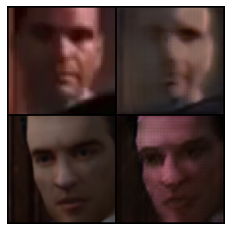

In [18]:
true_game_img, true_movie_img = next(loader)
true_game_img, true_movie_img = true_game_img.to("cuda"), true_movie_img.to("cuda")
gen_game_img = game_model.mov_2_game_G.forward(true_movie_img)
gen_mov_img = movie_model.game_2_mov_G.forward(true_game_img)

true_game_img = true_game_img.cpu().squeeze()
true_movie_img = true_movie_img.cpu().squeeze()
gen_game_img = gen_game_img.cpu().squeeze()
gen_mov_img = gen_mov_img.cpu().squeeze()
imgs = torch.cat((true_movie_img.unsqueeze(dim=0), gen_game_img.unsqueeze(dim=0), true_game_img.unsqueeze(dim=0), gen_mov_img.unsqueeze(dim=0)))
grid = torchvision.utils.make_grid(imgs, nrow=2)
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0))